In [1]:
!pip install peft

In [2]:
!pip install transformers accelerate evaluate datasets peft -q

In [3]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.35.2
Accelerate version: 0.24.1
PEFT version: 0.6.2


In [4]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [5]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

In [8]:
import torch
torch.cuda.is_available()

True

#### Dataset preparation
- To prepare the dataset for training and evaluation, create `label2id` and `id2label` dictionaries.

These will come in handy when performing inference and for metadata information:

In [6]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [7]:
id2label[2]

'baklava'

In [8]:
print(id2label)

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake', 15: 'ceviche', 16: 'cheesecake', 17: 'cheese_plate', 18: 'chicken_curry', 19: 'chicken_quesadilla', 20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder', 25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes', 30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots', 36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt', 46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon', 51: 'guacamole

In [9]:
len(id2label.keys())

101

In [10]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [11]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Split the dataset into training and validation sets:

In [13]:
splits   = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds   = splits["test"]

In [14]:
train_ds.shape

(4500, 2)

In [15]:
val_ds.shape

(500, 2)

#### Load and prepare a model
Before loading the model, let’s define a helper function to check the total number of parameters a model has, as well as how many of them are trainable.

In [16]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [17]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Before creating a PeftModel, you can check the number of trainable parameters in the original model:

In [18]:
print_trainable_parameters(model)


trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


Next, use get_peft_model to wrap the base model so that “update” matrices are added to the respective places.

In [19]:
from peft import LoraConfig, get_peft_model

In [20]:
config = LoraConfig(
    r         =16,
    lora_alpha=16,
    target_modules = ["query", "value"],
    lora_dropout   = 0.1,
    bias="none",
    modules_to_save=["classifier"],
)

In [21]:
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


- To use LoRA, you need to specify the target modules in LoraConfig so that get_peft_model() knows which modules inside our model need to be amended with LoRA matrices.

- In this example, we’re only interested in targeting the `query` and `value` matrices of the attention blocks of the base model.

- Since the parameters corresponding to these matrices are “named” “query” and “value” respectively, we specify them accordingly in the `target_modules` argument of `LoraConfig`.

We also specify modules_to_save. After wrapping the base model with get_peft_model() along with the config, we get a new model where only the LoRA parameters are trainable (so-called “update matrices”) while the pre-trained parameters are kept frozen. However, we want the classifier parameters to be trained too when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify modules_to_save. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like save_pretrained() and push_to_hub().

Here’s what the other parameters mean:

r: The dimension used by the LoRA update matrices.
alpha: Scaling factor.

bias: Specifies if the bias parameters should be trained. None denotes none of the bias parameters will be trained.

r and alpha together control the total number of final trainable parameters when using LoRA, giving you the flexibility to balance a trade-off between end performance and compute efficiency.

By looking at the number of trainable parameters, you can see how many parameters we’re actually training. Since the goal is to achieve parameter-efficient fine-tuning, you should expect to see fewer trainable parameters in the lora_model in comparison to the original model, which is indeed the case here.

#### Define training arguments
For model fine-tuning, use Trainer. It accepts several arguments which you can wrap using TrainingArguments.

In [22]:
from transformers import TrainingArguments, Trainer

In [23]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 128

In [24]:
args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

Compared to non-PEFT methods, you can use a larger batch size since there are fewer parameters to train. You can also set a larger learning rate than the normal (1e-5 for example).

This can potentially also reduce the need to conduct expensive hyperparameter tuning experiments.

#### Prepare evaluation metric

In [25]:
import numpy as np
import evaluate

In [26]:
metric = evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

The compute_metrics function takes a named tuple as input: predictions, which are the logits of the model as Numpy arrays, and label_ids, which are the ground-truth labels as Numpy arrays.

#### Define collation function
A collation function is used by Trainer to gather a batch of training and evaluation examples and prepare them in a format that is acceptable by the underlying model.

In [67]:
import torch


def collate_fn(examples):
    #pixel_values = torch.stack( [example["pixel_values"] for example in examples])
    pixel_values = torch.stack( [transform(example['image']) for example in examples])   # changed
    #pixel_values  = torch.stack(list(transform(example['image'])))

    labels       = torch.tensor([example["label"]        for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

#### Train and evaluate
Bring everything together - model, training arguments, data, collation function, etc. Then, start the training!

In [68]:
from huggingface_hub import notebook_login

notebook_login()

In [69]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset  = train_ds,
    eval_dataset   = val_ds,
    tokenizer      = image_processor,
    compute_metrics= compute_metrics,
    data_collator  = collate_fn,
)

In [72]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.625455,0.870000
2,2.134600,0.280370,0.916000
3,0.300800,0.254562,0.924000
4,0.139700,0.225331,0.928000
5,0.091600,0.222421,0.930000


In just a few minutes, the fine-tuned model shows 96% validation accuracy even on this small subset of the training dataset.

In [74]:
trainer.evaluate(val_ds)



{'eval_loss': 0.22242078185081482,
 'eval_accuracy': 0.93,
 'eval_runtime': 9.1933,
 'eval_samples_per_second': 54.388,
 'eval_steps_per_second': 0.435,
 'epoch': 5.0}

In [75]:
repo_name = f"gridflowAI/{model_name}-finetuned-lora-food101"
lora_model.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/gridflowai/vit-base-patch16-224-in21k-finetuned-lora-food101/commit/ac85bb1d1161242c765a7360e9b34b5255b78156', commit_message='Upload model', commit_description='', oid='ac85bb1d1161242c765a7360e9b34b5255b78156', pr_url=None, pr_revision=None, pr_num=None)

In [76]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)

(…)food101/resolve/main/adapter_config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

In [77]:
from PIL import Image
import requests

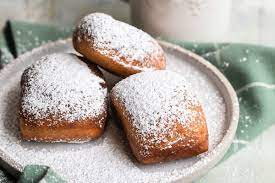

In [78]:
url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [79]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)

(…)01/resolve/main/preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

In [80]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [81]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: beignets


In [42]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 4500
})

In [ ]:
train_ds['image'][0].shape

In [35]:
import matplotlib.pyplot as plt

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x341 at 0x7BB0543B6B00>


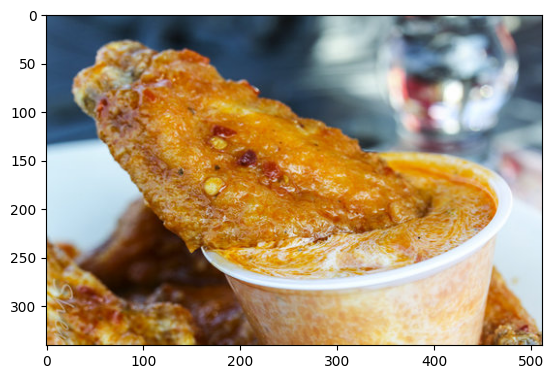

In [38]:
for example in val_ds:
    print(example['image'])
    plt.imshow(example['image'])
    break

In [42]:
import torchvision.transforms as transforms

In [71]:
# Define a transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

In [55]:
input_tensor = transform(val_ds[3]['image'])

In [56]:
input_tensor.shape

torch.Size([3, 512, 512])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x341 at 0x7BB042A93B20>


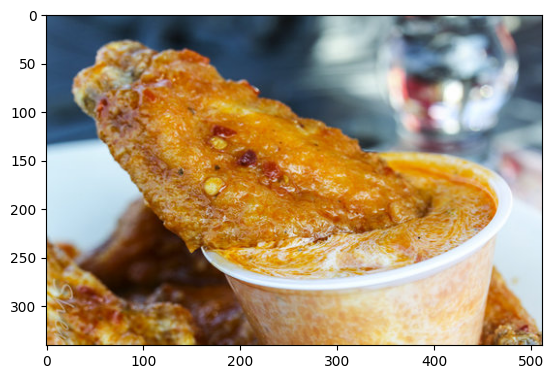

In [65]:
for example in val_ds:
    print(example['image'])
    plt.imshow(example['image'])
    pixel_values  = torch.stack(list(transform(example['image'])))

    break

In [66]:
pixel_values

tensor([[[0.2235, 0.2235, 0.2235,  ..., 0.4314, 0.4275, 0.4235],
         [0.2275, 0.2235, 0.2235,  ..., 0.4196, 0.4157, 0.4118],
         [0.2235, 0.2235, 0.2235,  ..., 0.4039, 0.4078, 0.4078],
         ...,
         [0.7961, 0.7961, 0.8078,  ..., 0.6510, 0.6431, 0.6784],
         [0.7922, 0.7961, 0.8078,  ..., 0.6549, 0.6157, 0.7098],
         [0.8000, 0.8000, 0.8078,  ..., 0.6902, 0.6000, 0.6353]],

        [[0.3529, 0.3529, 0.3529,  ..., 0.4980, 0.4941, 0.4902],
         [0.3569, 0.3529, 0.3529,  ..., 0.4863, 0.4824, 0.4784],
         [0.3569, 0.3569, 0.3529,  ..., 0.4706, 0.4627, 0.4627],
         ...,
         [0.5804, 0.5804, 0.5922,  ..., 0.5294, 0.5333, 0.5725],
         [0.5686, 0.5725, 0.5804,  ..., 0.5529, 0.5098, 0.6039],
         [0.5569, 0.5529, 0.5647,  ..., 0.5843, 0.4863, 0.5098]],

        [[0.4902, 0.4902, 0.4902,  ..., 0.5373, 0.5333, 0.5294],
         [0.4941, 0.4902, 0.4902,  ..., 0.5255, 0.5216, 0.5176],
         [0.4941, 0.4941, 0.4902,  ..., 0.5098, 0.5059, 0.